In [1]:
from scipy.optimize import minimize
import seaborn as sns
import pylab as plt
import numpy as np
import copy
import plot_functions as plotf
import bootstrap_functions as bootf
import model_functions as modelf
import read_experimental_data as e_data

sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3, 'axes.facecolor': 'white'})
%matplotlib inline

In [2]:
# Obtaining experimental data from Tam 1981.
d_WT, dMMC = e_data.readData_Tam1981()

d_WT['dt'] = 1.0
dMMC['dt'] = 1.0
# setting the time range (in min). t=0 equal to embryonic day 0.
d_WT['t']  = np.arange(12300, 18000, d_WT['dt'])
dMMC['t']  = np.arange(12800, 18400, dMMC['dt'])

# getting a boostrap fit of segmentation properties.  
bootf.fit_parameters(d_WT)
bootf.fit_parameters(dMMC)

# estimative of the embryonic time where somitogenesis process begin, i.e., somite stage = 0
d_WT['t0'] = 11807.5
dMMC['t0'] = 11854
# confirming if it is close to zero by transforming time in minutes to somite stage.
print np.polyval(d_WT['p_nSS'], d_WT['t0'])  
print np.polyval(dMMC['p_nSS'], dMMC['t0'])

0.007362100052887399
0.0008037336733082157


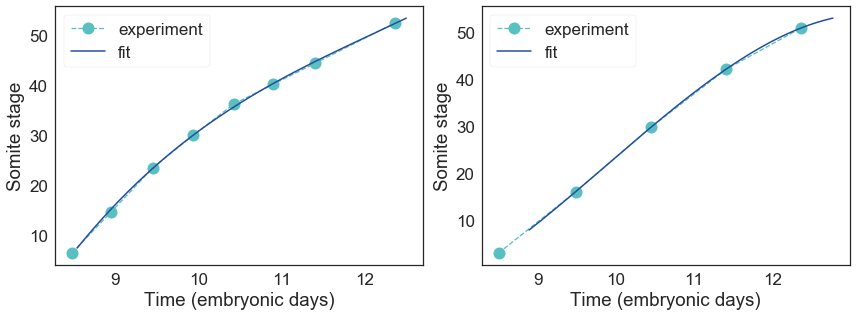

In [3]:
# Plot and fit the relationship between time and somite stage
fig = plt.subplots(1, 2, figsize=(6*2, 4.5), sharey=False)
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
plotf.SStomin(d_WT, ax=ax1)
plotf.SStomin(dMMC, ax=ax2)
plt.tight_layout()

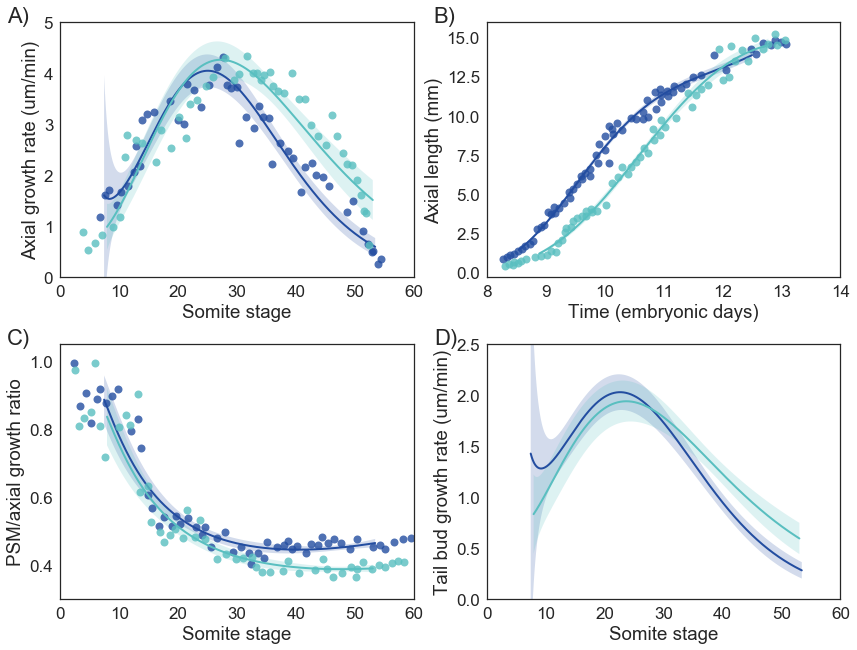

In [4]:
# plot growth properties and perform bootstrap fitting
plotf.growth_properties(d_WT, dMMC)#, save_fig='../figures/FigureS1_InVivo_GrowthProperties.pdf')

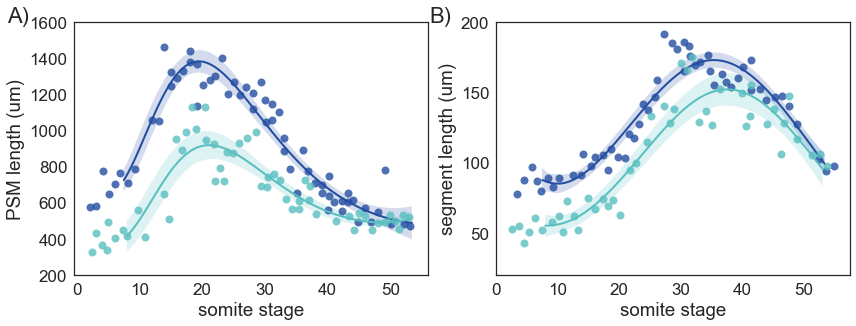

In [5]:
# fit experimental data and plot segmentation properties 
plotf.segmentation_properties(d_WT, dMMC)#, save_fig='../figures/FigureS2_InVivo_segmentProperties.pdf')

a =  114.91636470667652
b =  1087.5385079760542
gamma =  1e+100
theta =  1.024675590123
T0 =  65.99444705704178


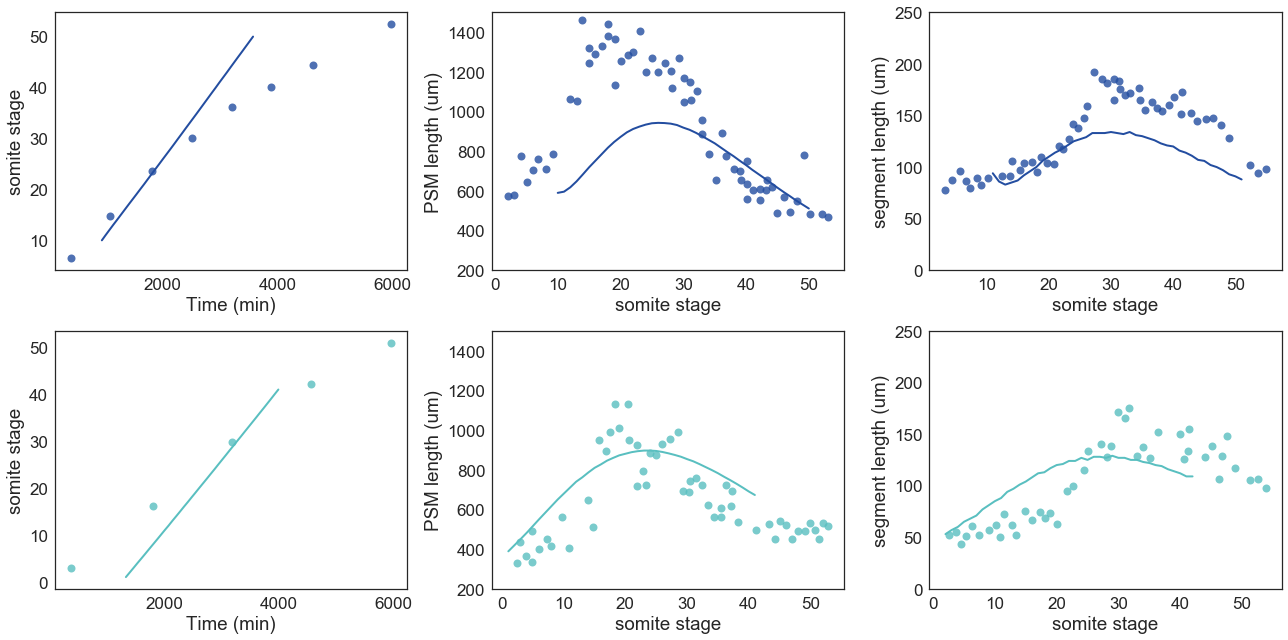

a =  105.2525232021527
b =  1125.5840602870246
gamma =  37.39937196579859
theta =  0.969552668649271
T0 =  74.583561978676


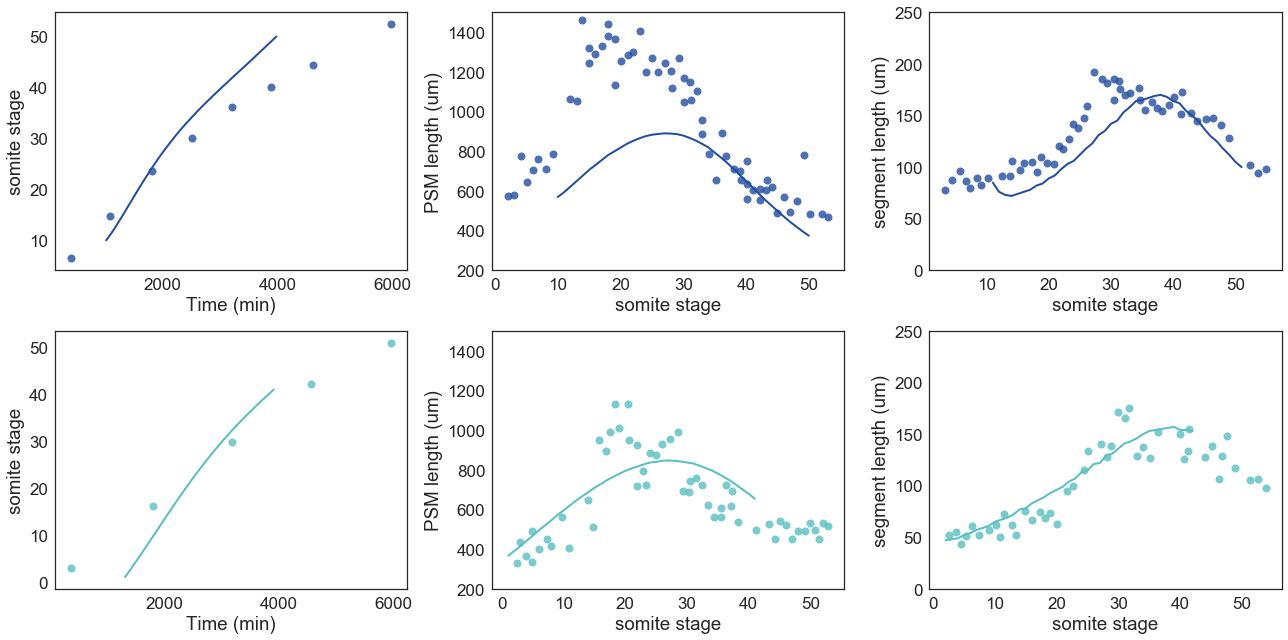

In [6]:
# getting a starting point, finding the best set of parameters that fit WT data.
d_WT['SS0'] = 10          # initial somite stage for fitting
dMMC['SS0'] = 1
d_WT['rSS'] = [10, 50]
dMMC['rSS'] = [10, 50]

# starting values of the parameters
p = {}
p['a']  = 150.
p['b']  = 1200.
p['T0'] = 100.
p['gamma'] = 30.
p['theta'] = 1.0
pcopy = copy.copy(p)

d_WT['g'] = d_WT['g_m']  # considering that the growth rate is the average value of bootstrap fitting.
dMMC['g'] = dMMC['g_m']

# ------- find the set of parameters that best fit experimental data (Both WT and MMC)------------
params = ['a', 'b', 'gamma', 'theta', 'T0']
xratio = [1.0, 1.0, 1.0, 1.0, 1.0]
bounds = ((0.2, 5.), (0.2, 5.), (0.2, 5.), (0.2, 5.), (0.2, 5.))     

# Checking the effect of excluding the parameter gamma
pcopy = copy.copy(p)
pcopy['gamma'] = 1e+100  # extreamly large number is the same as excluding this parameter.
out = modelf.minimize_bstrap([d_WT, dMMC], pcopy, params, xratio, bounds)
for i in range(len(params)):
    pcopy[params[i]] = out.x[i]*pcopy[params[i]]
    print params[i]+' = ', pcopy[params[i]]
plotf.modelfit([d_WT, dMMC], pcopy)
plt.show()

# Including the parameter gamma
pcopy = copy.copy(p)
out = modelf.minimize_bstrap([d_WT, dMMC], pcopy, params, xratio, bounds)
for i in range(len(params)):
    pcopy[params[i]] = out.x[i]*pcopy[params[i]]
    print params[i]+' = ', pcopy[params[i]]
plotf.modelfit([d_WT, dMMC], pcopy)

a =  144.41360497498928
b =  1171.3477243479492
gamma =  34.18692167731364
theta =  1.0028920784292612
T0 =  80.43238846210964


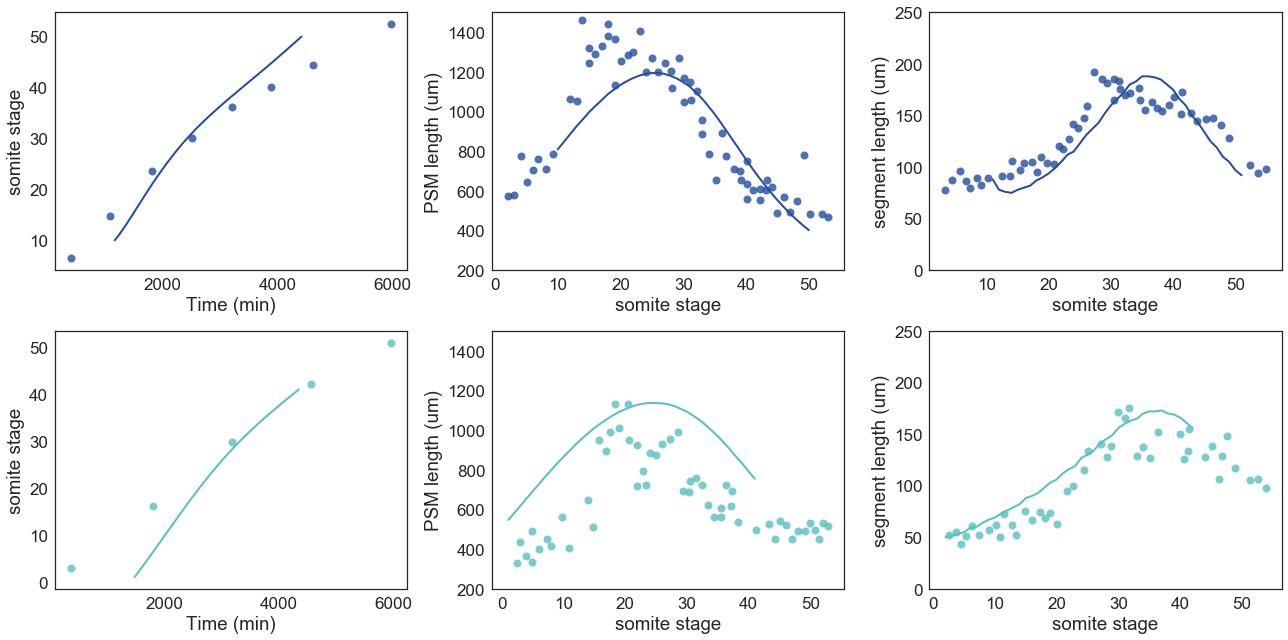

In [7]:
# # ------- find the set of parameters that best fit experimental data (Only WT data) ------------
# pcopy = copy.copy(p)
# pcopy['gamma'] = 1e+100
# out = modelf.minimize_bstrap([d_WT], pcopy, params, xratio, bounds)
# for i in range(len(params)):
#     pcopy[params[i]] = out.x[i]*pcopy[params[i]]
#     print params[i]+' = ', pcopy[params[i]]
# plotf.modelfit([d_WT, dMMC], pcopy)
# plt.show()

# Including the parameter gamma
# these values will be used as the starting point for further fit.
pcopy = copy.copy(p)
out = modelf.minimize_bstrap([d_WT], pcopy, params, xratio, bounds)
for i in range(len(params)):
    pcopy[params[i]] = out.x[i]*pcopy[params[i]]
    print params[i]+' = ', pcopy[params[i]]
plotf.modelfit([d_WT, dMMC], pcopy)

p = pcopy

In [8]:
# ------- get the best fit for different growth profile obtained from bootstrap ---------
nsampling = 100
x_WT = np.zeros((nsampling, len(params)))
xMMC = np.zeros((nsampling, len(params)))
for i in range(nsampling):
    d_WT['g'] = d_WT['g_bstrap'][:,i]    # growth rate from different bootstrap fitting
    out = modelf.minimize_bstrap([d_WT], p, params, xratio, bounds, maxiter=10)
    x_WT[i,:] = out.x
    dMMC['g'] = dMMC['g_bstrap'][:,i]
    out = modelf.minimize_bstrap([dMMC], p, params, xratio, bounds, maxiter=10)
    xMMC[i,:] = out.x

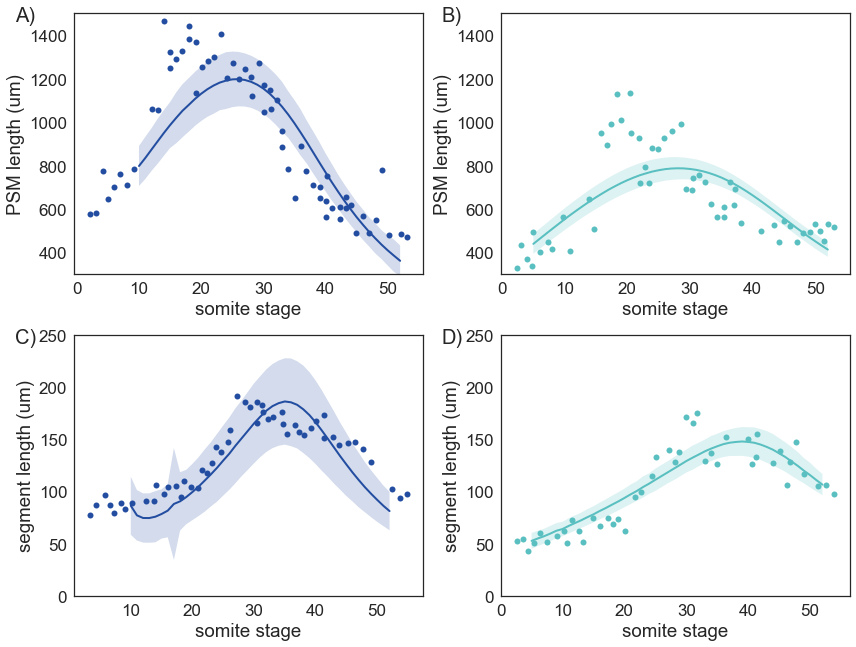

In [10]:
d_WT['rSS'] = [10, 52]    # range of the fit
dMMC['rSS'] = [5, 52]
plotf.bstrapfit(d_WT, dMMC, p, [x_WT, xMMC], params, save_fig='./figures/ModelFit_invivo.pdf')

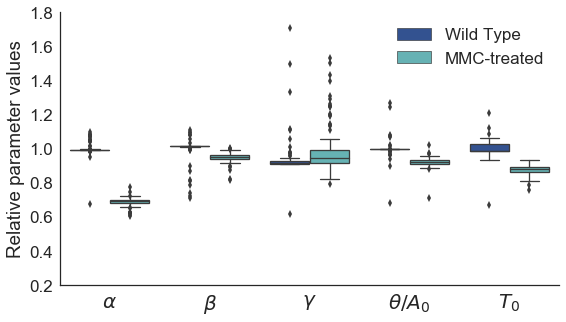

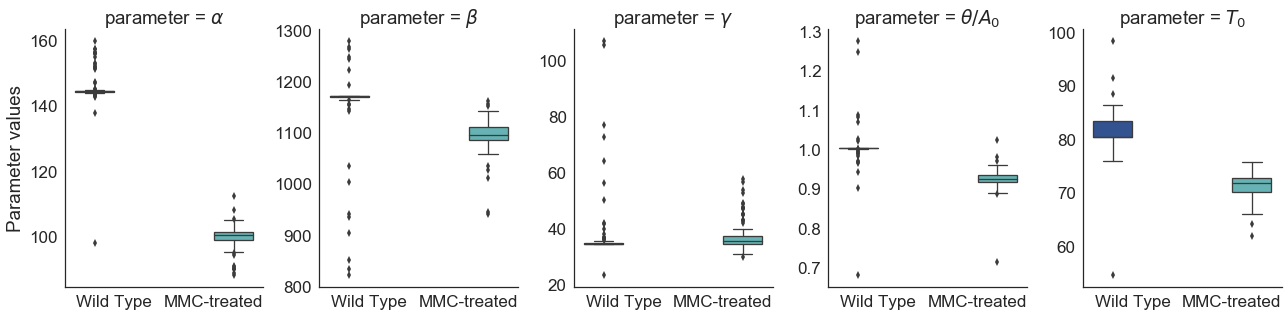

In [11]:
p_names = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\theta/A_0$', r'$T_0$']
label = ['Wild Type', 'MMC-treated']

plotf.parameter_values(x_WT, xMMC, p, params, p_names, label=label, aspect=1.8, ylim=[0.2, 1.8], save_fig='./figures/ModelFit_invivo_parameterValues.pdf')
plotf.parameter_values(x_WT, xMMC, p, params, p_names, label=label, aspect=0.8, relative_values=False, save_fig='./figures/ModelFit_invivo_parameterValues_Supp.pdf')

In [12]:
print 'Average and standart deviation of parameter values for WT:'
for i in range(len(params)):
    print params[i], np.mean(x_WT, axis=0)[i]*p[params[i]], np.std(x_WT, axis=0)[i]*p[params[i]]
print ''

print 'Average and standart deviation ofparameter values for MMC:'
for i in range(len(params)):
    print params[i], np.mean(xMMC, axis=0)[i]*p[params[i]], np.std(xMMC, axis=0)[i]*p[params[i]]

Average and standart deviation of parameter values for WT:
a 145.21280561240096 6.121262649945752
b 1153.9272323370599 76.41236929721063
gamma 37.535849142895835 12.03203158118606
theta 1.0039330125983195 0.05234134225148427
T0 81.37822729487819 4.005056465348022

Average and standart deviation ofparameter values for MMC:
a 99.58295860833094 3.6789097939662625
b 1092.9807225681361 31.707212294661613
gamma 37.31424276101696 5.319673378161299
theta 0.9245323835016122 0.02842074458214127
T0 71.22316485952821 2.391512686685156
